In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import abd_profile
import os
import pandas as pd
import GCN
import copy
import numpy as np
import tree_util
import se
from scipy.stats import mannwhitneyu
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.stats.multitest import fdrcorrection as fdr
import json

In [2]:
outer = '../result/GCN_fix_tree'
outdir = '../result/immu/SE'
ori_GCN = GCN.input_GCN('../data/gcn2008.tsv', transfer=True)
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
with open(os.path.join(outer, 'renamed_GCN_tree.newick')) as fp:
    newick_tree = fp.read()

In [3]:
json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
renamed_GCN = ori_GCN[list(d_df.columns)].rename(columns=name_dict)
renamed_d = d_df.rename(columns=name_dict, index=name_dict)
result = {}
# compute leaf layer
result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

In [4]:
result['leaves_dict']['root'] = {'root': list(name_dict.values())}
node_leaves['root'] = list(name_dict.values())

In [5]:
def fr(d_df, profile, sname):
    #print(profile.columns, d_df.index)
    sp_list = list(set(profile.columns).intersection(set(d_df.index)))
    #print(sp_list)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    fr_df = pd.DataFrame(value, index=sp_list, columns=sp_list)
    return fr_df

def multisample_se(profile, d_df, parent_dict, node_leaves, child_dict, direct_children_dict, param):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys())))
    for sname in profile.index:
        # print(sname)
        edge_df = fr(d_df, profile, sname)
        tmp = se.subtree_se_adj(edge_df, parent_dict, node_leaves, child_dict, direct_children_dict, param)
        for node in tmp.keys():
                value = tmp[node]
                result.loc[sname, node] = value
    return result


In [6]:
def main(indir, GCN_df, sp_d, result, name_dict, parent_dict, node_leaves, child_dict, direct_children_dict, param, cohort):
    #input dir: including metadata.tsv and abd.tsv
    # output result to dir
    abd_path = os.path.join(indir, 'merged_species.txt')
    metadata_path = os.path.join(indir, 'metadata.txt')

    # first process data from gutmeta
    raw_profile = abd_profile.input_profile(abd_path, transfer=True)
    metadata = pd.read_csv(metadata_path, sep=',', header=0)
    metadata.fillna('NA', inplace=True)
    metadata = metadata[(metadata['Cohort'] == cohort)] #  
    metadata = metadata[metadata['Sample Name'].isin(list(raw_profile.index))]
    

    selected_raw_profile = raw_profile.loc[list(metadata['Sample Name']), :]
    crc_profile = abd_profile.check(selected_raw_profile, GCN_df, name_dict)

    pheno_list = {}
    pheno_profiles = {}
    for i in metadata.index:
        pheno = metadata.loc[i, 'OS12']
        if pheno == 'NA':
            continue
        if pheno not in pheno_list.keys():
            pheno_list[pheno] = []
        if metadata.loc[i, 'Sample Name'] in list(crc_profile.index):
            pheno_list[pheno].append(metadata.loc[i, 'Sample Name'])

    for c, clist in pheno_list.items():
        pheno_profiles[c] = copy.deepcopy(crc_profile.loc[clist, :])
    # seperate by enterotypes

    
    level_se_result = {}   
    for p, profile in pheno_profiles.items():
        p_result = multisample_se(profile, sp_d, parent_dict, node_leaves, child_dict, direct_children_dict, param)
        for level, cluster_sp_dict in result['leaves_dict'].items():
            if level not in level_se_result.keys():
                level_se_result[level] = {}
            l_se = p_result.loc[:, list(cluster_sp_dict.keys())]
            level_se_result[level][p] = copy.deepcopy(l_se)
 
    return level_se_result

In [7]:
se_result = {}
outer = '../data'
cohort_list = ['Disc', 'Valid'] 
param = 0.5
indir= os.path.join(outer, 'immu')


In [8]:
se_result = {}
for cohort in cohort_list:
    level_b = main(indir, renamed_GCN, renamed_d, result, name_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict, param, cohort)
    se_result[cohort] = copy.deepcopy(level_b)


different sp: {'s__Ruminococcus_champanellensis', 's__Collinsella_stercoris', 's__Campylobacter_peloridis', 's__Candida_albicans', 's__Gemella_bergeri', 's__Giardia_intestinalis', 's__Granulicatella_elegans', 's__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae', 's__Sutterella_parvirubra', 's__Bacillus_circulans', 's__Cloacibacillus_evryensis', 's__[Collinsella]_massiliensis', 's__Olsenella_profusa', 's__Bulleidia_extructa'}
!!!difference species are deleted
different sp: {'s__Ruminococcus_champanellensis', 's__Collinsella_stercoris', 's__Campylobacter_peloridis', 's__Candida_albicans', 's__Gemella_bergeri', 's__Giardia_intestinalis', 's__Granulicatella_elegans', 's__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae', 's__Sutterella_parvirubra', 's__Bacillus_circulans', 's__Cloacibacillus_evryensis', 's__[Collinsella]_massiliensis', 's__Olsenella_profusa', 's__Bulleidia_extructa'}
!!!difference species are deleted


In [9]:
def output_se(se_result, outdir, cohort):
    odir = os.path.join(outdir, cohort)
    if not os.path.exists(odir):
        os.makedirs(odir)
    
    phenos = list(se_result[cohort]['root'].keys())
    
    for pheno in phenos:
        pheno_df = pd.DataFrame()
        for level, level_result in se_result[cohort].items():
            pheno_result = level_result[pheno]
            for node in pheno_result.columns:
                if node not in pheno_df.columns:
                    for sname in pheno_result.index:
                        pheno_df.loc[sname, node] = pheno_result.loc[sname, node]
        pheno_df.to_csv(os.path.join(odir, 'se_{}.tsv'.format(pheno)), sep='\t')

In [10]:
for cohort in se_result.keys():
    output_se(se_result, outdir, cohort)

In [11]:
if not os.path.exists(outdir):
    os.makedirs(outdir)
p_cutoff = 0.05


p_df = pd.DataFrame()
mean_df = pd.DataFrame()
valid_dict = {}
show_node = []
for level in result['leaves_dict'].keys():
    for cohort in se_result.keys():
        
        if 'NR' not in se_result[cohort][level].keys():
            continue
        if 'R' not in se_result[cohort][level].keys():
            continue
        if cohort not in valid_dict.keys():
            valid_dict[cohort] = []
        l_se1 = se_result[cohort][level]['NR']
        l_se2 = se_result[cohort][level]['R']
        for inode in l_se1.columns:
            if (list(l_se1[inode]).count(0) > len(list(l_se1[inode]))*0.8) and (list(l_se2[inode]).count(0) > len(list(l_se2[inode]))*0.8):
                continue
            valid_dict[cohort].append(inode)
            t, p1 = mannwhitneyu(list(l_se1[inode]), list(l_se2[inode]))
            p_df.loc[cohort, inode] = p1
            mean_df.loc[cohort, inode] = np.mean(l_se1[inode]) - np.mean(l_se2[inode])
p_df.fillna(np.nan, inplace=True)

In [12]:
for dir in p_df.index:
    valid_nodes = valid_dict[dir]
    p_vector = list(p_df.loc[dir, valid_nodes])
    p_adj = fdr(p_vector, p_cutoff)[1]
    for i, node in enumerate(valid_nodes):
        p_df.loc[dir, node] = p_adj[i]
p_df.to_csv(os.path.join(outdir, 'p_all_cohorts.tsv'), sep='\t')

In [13]:
node_plot = pd.DataFrame()
for dir in p_df.index:
    for inode in p_df.columns:
        p1 = p_df.loc[dir, inode]
        if pd.isna(p1):
            node_plot.loc[dir, inode] = np.nan
        elif p1 < p_cutoff:
            if mean_df.loc[dir, inode] > 0:
                node_plot.loc[dir, inode] = 1
            else:
                node_plot.loc[dir, inode] = -1
        else:
            node_plot.loc[dir, inode] = 0


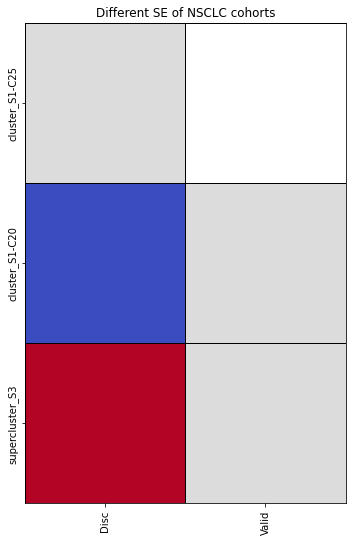

In [14]:
show_node = []   
part_df = node_plot
for inode in part_df.columns:
    all_zero = True
    all_nan = True
    for dir in part_df.index:
        if not pd.isna(node_plot.loc[dir, inode]):
            all_nan = False
        if node_plot.loc[dir, inode] != 0:
            all_zero = False
    if not (all_zero or all_nan):
        show_node.append(inode)
plt.figure(figsize=(5, 12))
part_df = part_df[show_node]
non_zero_count = part_df.astype(bool).sum(axis=0) - part_df.isnull().sum(axis=0)
sorted_df = part_df.iloc[:, non_zero_count.argsort()]
#show_node = sorted(show_node)
sns.heatmap(sorted_df.T, vmax=1, vmin=-1, square=True, linecolor='black', cbar=False, xticklabels=True, yticklabels=True, linewidths=1, cmap="coolwarm")
plt.title('Different SE of NSCLC cohorts')
plt.xticks(rotation=90)
ax = plt.gca()

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
opath = os.path.join(outdir, 'NSCLC.pdf')
plt.tight_layout()
plt.savefig(opath, dpi=300, format='pdf')
part_df[show_node].to_csv(os.path.join(outdir, 'NSCLC.tsv'), sep='\t')
#plt.show()
#print(part_df[show_node].shape)

In [67]:
# supercluster_S3 
# cluster_S1-C20

# binary disc set and find Score


abd_path = os.path.join(indir, 'merged_species.txt')
raw_profile = abd_profile.input_profile(abd_path, transfer=True)
raw_profile = raw_profile[list(set(d_df.index).intersection(set(raw_profile.columns)))]
metadata_path = os.path.join(indir, 'metadata.txt')
metadata = pd.read_csv(metadata_path, sep=',', header=0)
metadata.fillna('NA', inplace=True)
metadata_cohort = metadata[(metadata['Cohort'] == 'Disc')] #  
metadata_cohort = metadata_cohort[metadata_cohort['Sample Name'].isin(list(raw_profile.index))]
selected_raw_profile = raw_profile.loc[list(metadata_cohort['Sample Name']), :]
disc_profile = abd_profile.check(selected_raw_profile, d_df)
delete_sp = []
binary_disc = copy.deepcopy(disc_profile)
binary_disc[binary_disc > 0] = 1
for sp in disc_profile.columns:
    if binary_disc[sp].sum() < len(disc_profile)*2.5/100:
        delete_sp.append(sp)
disc_profile.drop(columns=delete_sp, inplace=True)

In [68]:
clusters = ['supercluster_S3', 'cluster_S1-C20']
interested_dict = {}
num_dict = {}

for cluster in clusters:
    leaves = node_leaves[cluster]
    leaves = [leaf.replace('-', '_') for leaf in leaves]
    common_sp = list(set(disc_profile.columns).intersection(set(leaves)))
    interested_dict[cluster] = copy.deepcopy(disc_profile[common_sp])
    num_dict[cluster] = len(common_sp)

with open(os.path.join(outdir, 'cluster.tsv'), 'w') as fp:
    s = 'cluster\tsize\tleaves\n'
    for cluster in clusters:
        s += '{}\t{}\t{}\n'.format(cluster, num_dict[cluster], ','.join(list(interested_dict[cluster].columns)))
    fp.write(s)
    

In [69]:
# binary disc set and find Score
cluster_ratio = {}
for cluster in clusters:
    cluster_p = interested_dict[cluster]
    column_medians = cluster_p.median()
    for sp in cluster_p.columns:
        cluster_p.loc[:, sp] = cluster_p.loc[:, sp] - column_medians[sp]
    cluster_p[cluster_p > 0] = 1
    cluster_p[cluster_p < 0] = 0
    total_n = num_dict[cluster]
    # sum by row
    sum_result = cluster_p.sum(axis=1)
    ratio = sum_result/total_n
    cluster_ratio[cluster] = copy.deepcopy(ratio)
result_score = (cluster_ratio[clusters[1]]-cluster_ratio[clusters[0]][cluster_ratio[clusters[0]].index]+1)/2
result_score.to_csv(os.path.join(outdir, 'score_disc.tsv'), sep='\t')

In [43]:
metadata_cohort = metadata[(metadata['Cohort'] == 'Valid')] #  
metadata_cohort = metadata_cohort[metadata_cohort['Sample Name'].isin(list(raw_profile.index))]
selected_raw_profile = raw_profile.loc[list(metadata_cohort['Sample Name']), :]
valid_profile = abd_profile.check(selected_raw_profile, d_df)
# binary valid set and find Score
cluster_ratio = {}
for cluster in clusters:
    cluster_sp = list(set(interested_dict[cluster].columns).intersection(set(valid_profile.columns)))
    cluster_p = copy.deepcopy(valid_profile[cluster_sp])
    column_medians = cluster_p.median()
    for sp in cluster_p.columns:
        cluster_p.loc[:, sp] = cluster_p.loc[:, sp] - column_medians[sp]
    cluster_p[cluster_p > 0] = 1
    cluster_p[cluster_p < 0] = 0
    total_n = num_dict[cluster]
    # sum by row
    sum_result = cluster_p.sum(axis=1)
    ratio = sum_result/total_n
    cluster_ratio[cluster] = copy.deepcopy(ratio)
result_score = (cluster_ratio[clusters[1]]-cluster_ratio[clusters[0]][cluster_ratio[clusters[0]].index]+1)/2
result_score.to_csv(os.path.join(outdir, 'score_valid.tsv'), sep='\t')

In [77]:
# Cohort OS Sample_id TOPOB01 OS12
DS1 = pd.read_csv('../data/immu/DS1_oncology_clinical_data.csv', header=0)
DS1 = DS1[DS1['Cohort']=='Disc']
DS1.set_index('Sample_id', inplace=True)
DS1.dropna(subset=['OS12'], inplace=True)
DS1['Sample_id'] = DS1.index

pred_disc = pd.read_csv(os.path.join(outdir, 'score_disc.tsv'), sep='\t', header=0, index_col=0)
DS1['TOPOB01'] = pred_disc.loc[DS1.index, '0']
DS1.to_csv(os.path.join(outdir, 'pred_disc.tsv'), sep='\t', index=False)


In [76]:
DS1.loc[DS1[DS1['TOPOB01'] < 0.498].index, 'TOPOB01'] = 0
DS1.loc[DS1[DS1['TOPOB01'] >= 0.629].index, 'TOPOB01'] = 1
pred_DS1 = DS1[(DS1['TOPOB01'] == 0) | (DS1['TOPOB01'] == 1)]
pred_DS1.to_csv(os.path.join(outdir, 'pred_binary_disc.tsv'), sep='\t', index=False)

In [98]:
print(len(pred_DS1[(pred_DS1['TOPOB01'] == 0) & (pred_DS1['OS12'] == 'R')]))
print(len(pred_DS1[(pred_DS1['TOPOB01'] == 0) & (pred_DS1['OS12'] == 'NR')]))
print(len(pred_DS1[(pred_DS1['TOPOB01'] == 1) & (pred_DS1['OS12'] == 'R')]))
print(len(pred_DS1[(pred_DS1['TOPOB01'] == 1) & (pred_DS1['OS12'] == 'NR')]))

13
34
56
34


In [100]:
34/(34+13)

0.723404255319149

In [101]:
56/(56+34)

0.6222222222222222

In [ ]:
pred_valid = pd.read_csv(os.path.join(outdir, 'score_valid.tsv'), sep='\t', header=0, index_col=0)

In [70]:
num_dict

{'supercluster_S3': 11, 'cluster_S1-C20': 19}

In [79]:
related_abd_df = pd.read_csv('../data/immu/sig.txt', sep='\t', header=0, index_col=None)
sig_dict = {}
sig_dict['sig1'] = list(related_abd_df[related_abd_df['SIG'] == 'SIG1']['MGS'])
sig_dict['sig1'] = [x.replace(' ', '_') for x in sig_dict['sig1']]
sig_dict['sig1'] = ['s__{}'.format(x) for x in sig_dict['sig1']]
sig_dict['sig2'] = list(related_abd_df[related_abd_df['SIG'] == 'SIG2']['MGS'])
sig_dict['sig2'] = [x.replace(' ', '_') for x in sig_dict['sig2']]
sig_dict['sig2'] = ['s__{}'.format(x) for x in sig_dict['sig2']]
sig_dict['sig3'] = list(set(raw_profile.columns).difference(set(sig_dict['sig1'] + sig_dict['sig2'])))

In [81]:
len(list(set(sig_dict['sig1']).intersection(set(raw_profile.columns))))

26

In [82]:
len(sig_dict['sig1'])

37

In [85]:
len(list(set(sig_dict['sig2']).intersection(set(interested_dict[clusters[0]].columns))))

0

In [86]:
len(list(set(sig_dict['sig1']).intersection(set(interested_dict[clusters[0]].columns))))

0

In [87]:
len(list(set(sig_dict['sig1']).intersection(set(interested_dict[clusters[1]].columns))))

0

In [88]:
len(list(set(sig_dict['sig2']).intersection(set(interested_dict[clusters[0]].columns))))

0

In [95]:
print(','.join(sig_dict['sig1']))
print(','.join(sig_dict['sig2']))

s__Actinomyces_graevenitzii,s__Alloscardovia_omnicolens,s__Anaerostipes_caccae,s__Bifidobacterium_dentium,s__Blautia_producta,s__Campylobacter_concisus,s__Campylobacter_gracilis,s__Clostridium_innocuum,s__Clostridium_perfringens,s__Clostridium_scindens,s__Clostridium_symbiosum,s__Collinsella_SGB14754,s__Enorma_massiliensis,s__Enterocloster_aldensis,s__Enterocloster_bolteae,s__Enterocloster_clostridioformis,s__Erysipelatoclostridium_ramosum,s__Fournierella_massiliensis,s__Granulicatella_adiacens,s__Hungatella_hathewayi,s__Lacticaseibacillus_paracasei,s__Lactobacillus_gasseri,s__Lactobacillus_vaginalis,s__Ligilactobacillus_salivarius,s__Limosilactobacillus_fermentum,s__Limosilactobacillus_oris,s__Megasphaera_micronuciformis,s__Proteus_mirabilis,s__Streptococcus_anginosus,s__Streptococcus_gordonii,s__Streptococcus_mutans,s__Streptococcus_oralis,s__Streptococcus_parasanguinis,s__Streptococcus_salivarius,s__Veillonella_atypica,s__Veillonella_dispar,s__Veillonella_parvula
s__Agathobaculum_bu

In [91]:
print(','.join(interested_dict[clusters[0]].columns))
print(','.join(interested_dict[clusters[1]].columns))

s__Escherichia_coli,s__Klebsiella_michiganensis,s__Enterobacter_cloacae_complex,s__Klebsiella_oxytoca,s__Klebsiella_quasipneumoniae,s__Klebsiella_variicola,s__Citrobacter_freundii,s__Hafnia_paralvei,s__Citrobacter_youngae,s__Hafnia_alvei,s__Klebsiella_pneumoniae
s__Lachnospira_pectinoschiza,s__Butyrivibrio_sp_CAG_318,s__Eubacterium_rectale,s__Firmicutes_bacterium_CAG_95,s__Roseburia_sp_CAG_309,s__Clostridium_sp_CAG_167,s__Roseburia_sp_CAG_303,s__Butyrivibrio_crossotus,s__Roseburia_sp_CAG_182,s__Roseburia_intestinalis,s__Eubacterium_eligens,s__Lactobacillus_rogosae,s__Bacteroides_galacturonicus,s__Roseburia_faecis,s__Clostridium_sp_CAG_253,s__Roseburia_hominis,s__Coprococcus_eutactus,s__Roseburia_inulinivorans,s__Eubacterium_sp_CAG_38
